<h1>Sieci neuronowe - ćwiczenie 4</h1>

In [1]:
!pip install ucimlrepo
!pip install tensorflow


[notice] A new release of pip available: 22.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

import tensorflow as tf
from tensorflow.keras.layers import Dense

<h3>Przygotowanie danych na podstawie poprzedniego ćwiczenia</h3>

In [3]:
# original code from https://archive.ics.uci.edu/dataset/45/heart+disease
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
heart_data = heart_disease.data.original

In [4]:
df: pd.DataFrame = heart_data

# repearing of the inbalnace in classification and removing null values
df["num"] = df["num"].replace([2, 3, 4], 1) #change classes to binary classification
print(df["num"].value_counts())

#get null values of ca and remove them
null_idx = df[df["ca"].isnull()].index 
print(null_idx)
df = df.drop(null_idx)
df = df.reset_index(drop=True) 
print(df["num"].value_counts())

#get null values of thel and remove them
null_idx = df[df["thal"].isnull()].index 
print(null_idx)
df = df.drop(null_idx)
df = df.reset_index(drop=True) 
print(df["num"].value_counts())

# balance classes to same amount 138
random_idx = df.query("num == 0").sample(df["num"].value_counts()[0] - df["num"].value_counts()[1]).index 
df = df.drop(random_idx)
df = df.reset_index(drop=True)
print(df["num"].value_counts())

df_without_num = df.loc[:, df.columns != "num"]
# std_features = (df_without_num - df_without_num.mean() )/ df_without_num.std() #(value-mean)/variance
std_features = (df_without_num - df_without_num.min()) / (df_without_num.max() - df_without_num.min()) #(value-mean)/variance

result_df = std_features
result_df["heart_disease"] = df["num"]

# data not standarized 4. Danych znormalizowanych i nieznormalizowanych
n_std_result = df_without_num
n_std_result["heart_disease"] = df["num"]

result_df


num
0    164
1    139
Name: count, dtype: int64
Index([166, 192, 287, 302], dtype='int64')
num
0    161
1    138
Name: count, dtype: int64
Index([87, 264], dtype='int64')
num
0    160
1    137
Name: count, dtype: int64
num
0    137
1    137
Name: count, dtype: int64


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heart_disease
0,0.674419,1.0,0.000000,0.481132,0.244292,1.0,1.0,0.637097,0.0,0.370968,1.0,0.000000,0.75,0
1,0.767442,1.0,1.000000,0.622642,0.365297,0.0,1.0,0.298387,1.0,0.241935,0.5,1.000000,0.00,1
2,0.767442,1.0,1.000000,0.245283,0.235160,0.0,1.0,0.467742,1.0,0.419355,0.5,0.666667,1.00,1
3,0.069767,1.0,0.666667,0.339623,0.283105,0.0,0.0,0.935484,0.0,0.564516,1.0,0.000000,0.00,0
4,0.162791,0.0,0.333333,0.339623,0.178082,0.0,1.0,0.814516,0.0,0.225806,0.0,0.000000,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,0.534884,0.0,1.000000,0.433962,0.262557,0.0,0.0,0.419355,1.0,0.032258,0.5,0.000000,1.00,1
270,0.255814,1.0,0.000000,0.150943,0.315068,0.0,0.0,0.491935,0.0,0.193548,0.5,0.000000,1.00,1
271,0.790698,1.0,1.000000,0.471698,0.152968,1.0,0.0,0.564516,0.0,0.548387,0.5,0.666667,1.00,1
272,0.534884,1.0,1.000000,0.339623,0.011416,0.0,0.0,0.354839,1.0,0.193548,0.5,0.333333,1.00,1


In [5]:
def train_test_split(features, targets, percentage):
    choices = np.random.choice(range(features.shape[0]), size=(int(features.shape[0] * percentage/100),), replace=False) 
    split = np.zeros(features.shape[0], dtype=bool)
    split[choices] = True

    return features[split], targets[split], features[~split], targets[~split]

In [6]:
features = result_df.loc[:, result_df.columns != "heart_disease"].to_numpy()
targets = result_df["heart_disease"].to_numpy()

x_train, y_train, x_test, y_test = train_test_split(features, targets, 80)

<h1>Przygotowanie modelu</h1>

In [7]:
class MultilayerNetwork(tf.keras.Model):
    def __init__(self, hidden_layers_sizes: tuple, input_size: int, output_size: int):
        super(MultilayerNetwork, self).__init__()

        self._layers = []
        curr_size = input_size
        for hidden_layer_size in hidden_layers_sizes:
            layer = tf.keras.layers.Dense(hidden_layer_size, activation="sigmoid", input_shape=(curr_size,))
            self._layers.append(layer)
            curr_size = hidden_layer_size
        output_layer = tf.keras.layers.Dense(output_size, activation="sigmoid", input_shape=(curr_size,))    
        self._layers.append(output_layer)
        
    def call(self, inputs):
        x = inputs
        for layer in self._layers:
            x = layer(x)
        return x        

In [8]:
def train_model(model, x_train: np.ndarray, y_train: np.ndarray, x_test: np.ndarray, y_test: np.ndarray, batch_size: int,
                optimizer, loss, max_iter, verb=False):
    
    losses = []
    losses_test = []

    accuracy = []
    precision = []
    f_score = []
    recalls = []

    #fix shape of y data to match further calculations
    if len(y_test.shape) == 1:
        y_test = tf.transpose(y_test)

    if len(y_train.shape) == 1:
        y_train = tf.transpose(y_train)

    if batch_size > x_train.shape[0]:
        batch_size = x_train.shape[0]

    for index in range(max_iter): #learn for max_iter     
        # shuffle training data
        shuffle = np.random.permutation(x_train.shape[0])
        x_train_shuffled = tf.gather(x_train, shuffle)
        y_train_shuffled = tf.gather(y_train, shuffle)

        # for each batch perform learning
        for batch_start_index in range(0, x_train.shape[0], batch_size):
            x_train_batch = x_train_shuffled[batch_start_index:batch_start_index+batch_size] 
            y_train_batch = y_train_shuffled[batch_start_index:batch_start_index+batch_size] 

            with tf.GradientTape() as tape:
                y_pred = model(x_train_batch)
                y_pred = tf.squeeze(y_pred)
                loss_value = loss(y_train_batch, y_pred)
                loss_value = tf.reduce_mean(loss_value)
                
            gradient = tape.gradient(loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(gradient, model.trainable_variables))
        
        losses.append(loss_value.numpy())
        test_pred = model(x_test)
        test_pred = tf.squeeze(test_pred)
        loss_test_value = loss(y_test, test_pred)
        loss_test_value = tf.reduce_mean(loss_test_value)
        losses_test.append(loss_test_value.numpy())

        test_pred = tf.where(test_pred >= 0.5, 1.0, test_pred)
        test_pred = tf.where(test_pred < 0.5, 0.0, test_pred)

        #calculate scores for each iteration
        accuracy.append(metrics.accuracy_score(y_test, test_pred))
        precision.append(metrics.precision_score(y_test, test_pred))
        f_score.append(metrics.f1_score(y_test, test_pred))
        recalls.append(metrics.recall_score(y_test, test_pred))

        if verb and index % 100 == 0:
            print("---------------------------------------------- Interation " + str(index))
            print("Train loss on " + str(index) + " iteration: ", losses[index])
            print("Test loss on " + str(index) + " iteration: ", losses_test[index])
            print("Accuracy on " + str(index) + " iteration: ", accuracy[index])
            print("Precision on " + str(index) + " iteration: ", precision[index])
            print("Recall on " + str(index) + " iteration: ", recalls[index])
            print("Fscore on " + str(index) + " iteration: ", f_score[index])
            print("----------------------------------------------\n")

    print("Result of learning process for " + str(max_iter) + " iterations")
    print("--------------------------------------------------------\n")
    print("Train loss: ", losses[-1])
    print("Test loss: ", losses_test[-1])
    print("----------------------------------------------\n")
    print("Scores")
    print("Accuracy: ", accuracy[-1])
    print("Precision: ", precision[-1])
    print("F_score: ", f_score[-1])
    print("Recall: ", recalls[-1])    
    return losses, losses_test, accuracy, f_score, recalls

In [9]:
def plot_learning(losses: list, losses_test: list, title: str, axs = None):
    if axs == None:
        plt.plot(np.arange(len(losses)), losses, label="Train Loss")
        plt.plot(np.arange(len(losses)), losses_test, label="Test loss")
        plt.plot(np.convolve(losses, np.ones(30)/30, mode='valid'), label="Train loss smooth") #rolling avarage to smooth line
        plt.title(title)
        plt.legend()
        plt.show()
    else:
        axs.plot(np.arange(len(losses)), losses, label="Train Loss")
        axs.plot(np.arange(len(losses)), losses_test, label="Test loss")
        axs.plot(np.convolve(losses, np.ones(30)/30, mode='valid'), label="Train loss smooth") #rolling avarage to smooth line
        axs.set_title(title)
        axs.legend()

In [10]:
loss = tf.keras.losses.binary_crossentropy
learning_rate = 0.0001
batch_size = 30
iter = 1000
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate)

x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)

In [11]:
import warnings
warnings.filterwarnings('ignore') #hide warning for precision (first iterations have no precision and python gives a warning, to clear output hide it)

---------------------------------------------- Interation 0
Train loss on 0 iteration:  0.69186425
Test loss on 0 iteration:  0.6919344
Accuracy on 0 iteration:  0.5272727272727272
Precision on 0 iteration:  0.5272727272727272
Recall on 0 iteration:  1.0
Fscore on 0 iteration:  0.6904761904761904
----------------------------------------------

---------------------------------------------- Interation 100
Train loss on 100 iteration:  0.6851773
Test loss on 100 iteration:  0.69202244
Accuracy on 100 iteration:  0.4727272727272727
Precision on 100 iteration:  0.0
Recall on 100 iteration:  0.0
Fscore on 100 iteration:  0.0
----------------------------------------------

---------------------------------------------- Interation 200
Train loss on 200 iteration:  0.68660337
Test loss on 200 iteration:  0.68906397
Accuracy on 200 iteration:  0.509090909090909
Precision on 200 iteration:  1.0
Recall on 200 iteration:  0.06896551724137931
Fscore on 200 iteration:  0.12903225806451613
----------

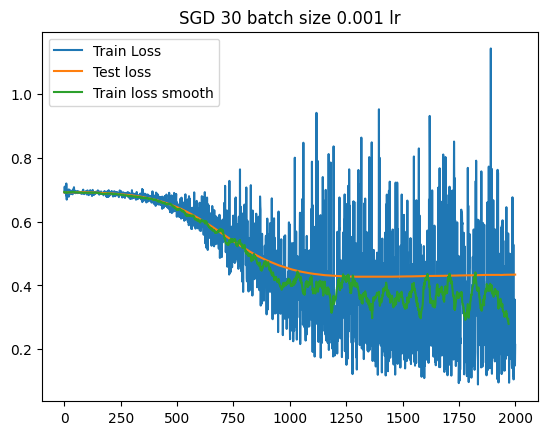

In [12]:
model = MultilayerNetwork((10,10,10), x_train.shape[1], 1)
result = train_model(model, x_train, y_train, x_test, y_test, batch_size, optimizer, loss, iter, verb=True)
plot_learning(result[0], result[1], "SGD 30 batch size 0.001 lr")


In [13]:
print(model.predict(x_test)[35])
y_test[35]


2/2 [==============================] - 0s 1ms/step
[0.40654585]


<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [14]:
#1. Różna wymiarowość warstwy ukrytej
hidden1 = (4, 3)
hidden2 = (20, 10)
hidden3 = (100, 50)

#2. Różne wartości współczynnika uczenia
learning1 = 0.001
learning2 = 0.01

#3. Różne odchylenia standardowych przy inicjalizacji wag
std_dev1 = 0.8
std_dev2 = 0.3

#5. Różne liczby warstw
hidden4 = (20,)
hidden5 = (20, 20)
hidden6 = (20, 20, 20)

max_iter = 500

options_title = ["hidden_layer " + str(hidden1), "hidden_layer " + str(hidden2), "hidden_layer " + str(hidden3),
           "learning " + str(learning1), "learning " + str(learning2),
           "std_dev " + str(std_dev1), "std_dev " + str(std_dev2),
           "layer size " + str(hidden4), "layer size " + str(hidden5), "layer size " + str(hidden6),
           "stadarized data", "not standarized data"]

options = [[hidden1, learning1, std_dev2], [hidden2, learning1, std_dev2], [hidden3, learning1, std_dev2],
           [hidden2, learning1, std_dev2], [hidden2, learning2, std_dev2],
           [hidden2, learning1, std_dev1], [hidden2, learning1, std_dev2],
           [hidden4, learning1, std_dev2], [hidden5, learning1, std_dev2], [hidden6, learning1, std_dev2]]

In [15]:
hidden_layers = [hidden1, hidden2, hidden3]
results = []
models = []
for index_option, option in enumerate(options):
    print("\n" + options_title[index_option])
    model = MultilayerNetwork(option[0])
    result = model.optimize(x_train, y_train, x_test, y_test, 30, option[1], max_iter, option[2], verb=True)
    models.append(model)
    results.append(result)


hidden_layer (4, 3)


TypeError: MultilayerNetwork.__init__() missing 2 required positional arguments: 'input_size' and 'output_size'

In [ ]:
features_n_std = n_std_result.loc[:, result_df.columns != "heart_disease"].to_numpy()
targets_n_std = n_std_result["heart_disease"].to_numpy()

x_train_n_std, y_train_n_std, x_test_n_std, y_test_n_std = train_test_split(features_n_std, targets_n_std, 70)

model_std = MultilayerNetwork(hidden2)
result = model_std.optimize(x_train, y_train, x_test, y_test, 30, 0.001, max_iter, 0.5, verb=True)
models.append(model_std)
results.append(result)

model_n_std = MultilayerNetwork(hidden2)
result = model_n_std.optimize(x_train_n_std, y_train_n_std, x_test_n_std, y_test_n_std, 30, 0.001, max_iter, 0.5, verb=True)
models.append(model_n_std)
results.append(result)

In [ ]:
plt.style.use('seaborn-muted')
fig, axs = plt.subplots(6, 2, figsize=(20, 25))

for model_index, model in enumerate(models):
    x_index = int(model_index / 2)
    y_index = int(model_index % 2)
    model.plot_learning(results[model_index][0], results[model_index][1], options_title[model_index], axs[x_index, y_index])
    